# Pipeline for High-z Radio Galaxies 03: Radio detection classification with confirmed AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, brier_score_loss
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

***

## Reading data

We import our data using the `pandas` package.

In [4]:
save_plot_flag         = False
save_model_flag        = False
read_idx_flag          = True
use_AGN_gal_model_flag = False
load_model_flag        = True
use_calibration        = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [5]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Z', 'zsp', 'Sint_LOFAR', 'W1mag', 'W2mag', 'spCl', 
                      'num_imputed', 'radio_detect'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [6]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [7]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources (in general, do not use this).

In [8]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [9]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_AGN"] == 1):,} confirmed AGN in this dataset.')

There are 50,538 confirmed AGN in this dataset.


In [10]:
if use_AGN_gal_model_flag:
    AGN_gal_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # From ML_16.ipynb

In [11]:
if use_AGN_gal_model_flag:
    new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                           probability_threshold=gv.AGN_thresh,\
                                           raw_score=True).loc[:, 'Score_1']

In [12]:
if use_AGN_gal_model_flag:
    full_catalog_df['class'] = new_labels_train.copy()

In [13]:
if use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely AGN

In [14]:
if use_AGN_gal_model_flag:
    AGN_threshold = 0.95
    gal_threshold = 0.05

In [15]:
if use_AGN_gal_model_flag:
    filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
    filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [16]:
if not use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [17]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [18]:
target_feat = 'LOFAR_detect'

## Possible correlations

In [19]:
print(full_catalog_df.columns.to_list())

['band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4', 'class']


---

Create target

In [20]:
full_catalog_df.loc[:, target_feat] = full_catalog_df.loc[:, target_feat].astype(int)

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`class == 1`)

In [21]:
filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df   = full_catalog_df.loc[filter_known_spec]
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'class', use_calibration=use_calibration)
if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (118734, 86)
Data for Modeling (Train, Test, and Calibration): (94987, 86)
Training data:                                    (75989, 86)
Testing data:                                     (9499, 86)
Calibration data:                                 (9499, 86)
Validation data:                                  (23747, 86)
------------------------------------------------------------



In [22]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'class'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'class'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'class'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'class'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'class'] == 1)]

In [23]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, target_feat] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 50,538 elements,
50,538 of them are marked as AGN, and, from them, 6,419 have confirmed radio detection.


Remove intermediate targets

In [24]:
cols_to_discard_classes = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'class', 'is_str']
full_catalog_df = full_catalog_df.drop(columns=cols_to_discard_classes)
train_test_df   = train_test_df.drop(columns=cols_to_discard_classes)
train_df        = train_df.drop(columns=cols_to_discard_classes)
test_df         = test_df.drop(columns=cols_to_discard_classes)
calibration_df  = calibration_df.drop(columns=cols_to_discard_classes)
validation_df   = validation_df.drop(columns=cols_to_discard_classes)

---

In [25]:
print('Final shape of used data')
print('-' * 65)
print('(Confirmed AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 65)

Final shape of used data
-----------------------------------------------------------------
(Confirmed AGN)
--------------------------------------------------
Full confirmed dataset size:        (50538, 80)
Data for Modeling (Train and Test): (40430, 80)
Training data:                      (32344, 80)
Testing data:                       (4043, 80)
Calibration data:                   (4043, 80)
Validation data:                    (10108, 80)
-----------------------------------------------------------------


---

## Use Correlation matrix to discard some features

In [26]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [27]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [28]:
rsd_vals

K_W3            1476.038069
z_y              621.079596
i_z              307.791209
LOFAR_detect     262.585471
i_y              262.346885
r_i              172.492411
r_y              155.134435
g_r              142.022906
r_z              140.578856
g_y              110.466812
g_i              108.840600
g_z              100.727724
W1_W2             77.310927
y_W1              67.650403
z_W1              58.634340
i_W1              53.561978
r_W1              51.855600
H_W3              51.491359
g_W1              51.087485
y_W2              50.688407
z_W2              43.592536
i_W2              39.622813
J_W3              39.174098
r_W2              38.665909
g_W2              38.616145
y_J               37.522935
y_H               34.772186
z_J               34.093793
i_J               32.814786
W2_W3             32.428631
z_H               31.661418
r_J               31.646608
i_H               30.564282
g_J               29.899220
r_H               29.600808
y_K               29

In [29]:
correlation    = norm_train_test_df.corr()

In [30]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [31]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [32]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [33]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [34]:
list_drop_corr

['y_H',
 'g_H',
 'r_H',
 'z_H',
 'i_H',
 'J_W1',
 'J_W2',
 'y_K',
 'r_K',
 'g_K',
 'i_K',
 'z_K',
 'J_W3',
 'H_W1',
 'H_W2',
 'Jmag',
 'J_W4',
 'K_W1',
 'K_W2',
 'ymag',
 'rmag',
 'gmag',
 'imag',
 'zmag',
 'W1mproPM',
 'W2mproPM',
 'y_W4',
 'g_W4',
 'r_W4',
 'i_W4',
 'z_W4',
 'W1_W4',
 'W2_W4',
 'Kmag',
 'H_W3',
 'r_J',
 'g_W2',
 'r_W3',
 'W1_W3',
 'y_W3',
 'J_K',
 'g_W3',
 'i_J',
 'z_W3',
 'r_W2',
 'y_W2',
 'z_W2',
 'i_W2',
 'g_W1',
 'r_W1',
 'H_W4',
 'W3mag',
 'z_J',
 'Hmag',
 'g_y',
 'i_W1',
 'r_y',
 'W3_W4',
 'i_W3',
 'g_J',
 'i_y',
 'g_z']

In [35]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [36]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [37]:
corr_discard = norm_train_test_discard.corr()

In [38]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
g_r       g_i         0.748791
W2_W3     y_J         0.730483
z_W1      y_W1        0.700692
y_J       band_num    0.692459
i_z       r_z         0.689555
K_W3      W4mag       0.668929
r_i       g_i         0.651105
K_W3      K_W4        0.629164
K_W4      W4mag       0.580843
band_num  W2_W3       0.578742
r_i       r_z         0.545572
y_J       y_W1        0.502724
          K_W3        0.492404
z_y       y_W1        0.456185
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

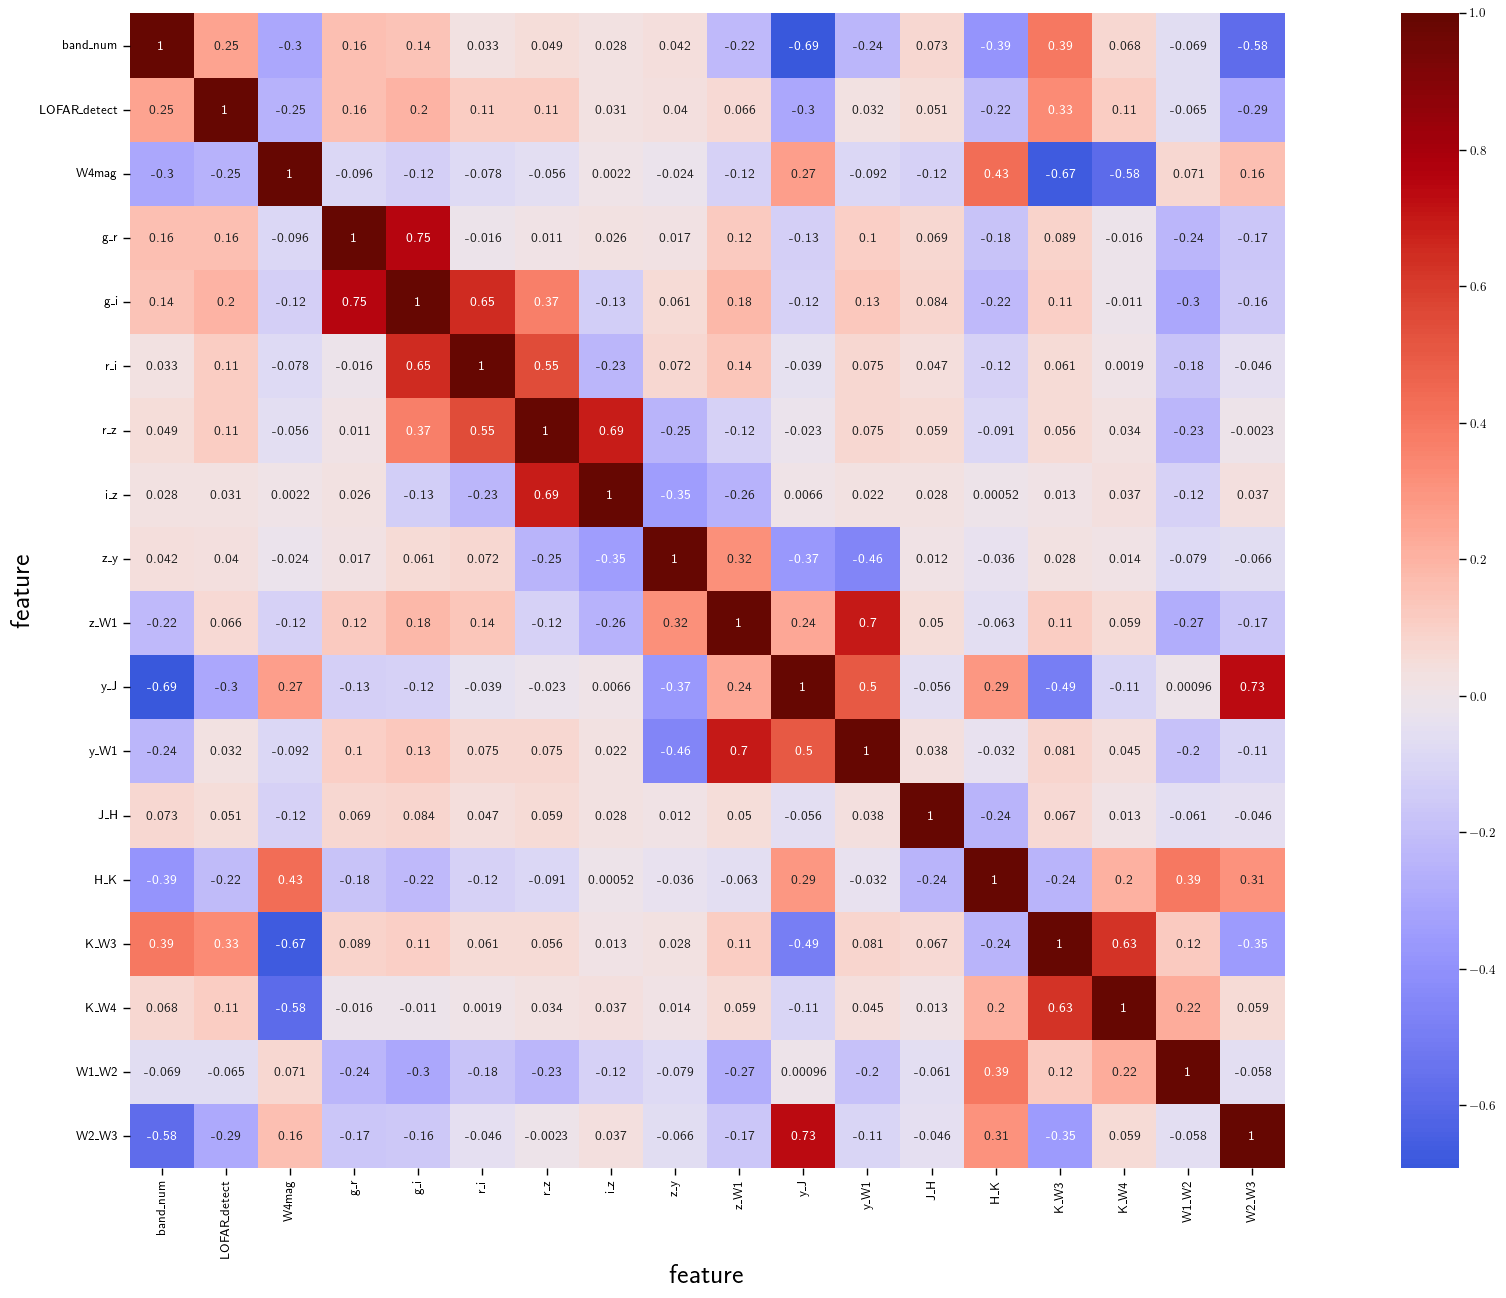

In [39]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [40]:
norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [41]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [42]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
H_K       H_K             1.000000
band_num  y_J             0.590324
K_W4      W4mag           0.443314
K_W3      K_W4            0.402417
band_num  z_y             0.332394
J_H       H_K             0.311224
z_y       y_J             0.283313
band_num  W2_W3           0.270832
K_W3      W4mag           0.224071
y_W1      y_J             0.217258
          z_W1            0.212328
band_num  y_W1            0.203703
y_J       band_num        0.202022
K_W3      W2_W3           0.194977
W2_W3     y_J             0.194251
y_J       W2_W3           0.191061
z_W1      y_W1            0.179761
K_W3      LOFAR_detect    0.169193
W4mag     LOFAR_detect    0.168469
g_r       g_i             0.165841
dtype: float64

In [43]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [44]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [45]:
list_drop_pps = []

In [46]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [47]:
list_drop_pps

[]

In [48]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [49]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [50]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,K_W3,LOFAR_detect,0.169193,classification,True,weighted F1,0.81638,0.847448,DecisionTreeClassifier()
1,W4mag,LOFAR_detect,0.168469,classification,True,weighted F1,0.81638,0.847315,DecisionTreeClassifier()
2,K_W4,LOFAR_detect,0.149795,classification,True,weighted F1,0.81638,0.843886,DecisionTreeClassifier()
3,band_num,LOFAR_detect,0.123643,classification,True,weighted F1,0.81638,0.839084,DecisionTreeClassifier()
4,J_H,LOFAR_detect,0.084144,classification,True,weighted F1,0.81638,0.831831,DecisionTreeClassifier()
5,H_K,LOFAR_detect,0.064152,classification,True,weighted F1,0.81638,0.828160,DecisionTreeClassifier()
6,g_r,LOFAR_detect,0.000000,classification,True,weighted F1,0.81638,0.794900,DecisionTreeClassifier()
7,g_i,LOFAR_detect,0.000000,classification,True,weighted F1,0.81638,0.796503,DecisionTreeClassifier()
8,r_i,LOFAR_detect,0.000000,classification,True,weighted F1,0.81638,0.792409,DecisionTreeClassifier()
9,r_z,LOFAR_detect,0.000000,classification,True,weighted F1,0.81638,0.783665,DecisionTreeClassifier()


In [51]:
print(f'{len(full_catalog_df):,}')

50,538


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [52]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [53]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards no features.

In [55]:
exp_radio = pyc.setup(data                     = train_df,
                      test_data                = test_df,
                      target                   = target_feat,
                      session_id               = gv.seed,
                      silent                   = True,
                      feature_selection        = False,
                      feature_selection_method = 'boruta',
                      data_split_stratify      = True,
                      numeric_features         = final_feats,
                      ignore_features          = feats_2_discard,
                      transformation           = True,
                      transformation_method    = 'yeo-johnson',
                      n_jobs                   = 12,
                      normalize                = True,
                      normalize_method         = 'zscore',
                      use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,LOFAR_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(32344, 80)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [56]:
pyc.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'g_i', 'r_i', 'r_z', 'i_z', 'z_y', 'z_W1',
       'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W2_W3'],
      dtype='object')

In [56]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Add F_beta score ($\beta = 1.1$).

In [57]:
pyc.add_metric('f_beta', 'F_score', gf.f_beta, greater_is_better=True)

Name                                             F_score
Display Name                                     F_score
Score Function       <function f_beta at 0x7fb8059c13a0>
Scorer                               make_scorer(f_beta)
Target                                              pred
Args                                                  {}
Greater is Better                                   True
Multiclass                                          True
Custom                                              True
Name: f_beta, dtype: object

In [58]:
pyc.models(internal=True).loc['catboost']['Tune Grid'].keys()

dict_keys(['eta', 'depth', 'n_estimators', 'random_strength', 'l2_leaf_reg'])

In [60]:
pyc.models(internal=True).loc['xgboost']['Tune Grid'].keys()

dict_keys(['learning_rate', 'n_estimators', 'subsample', 'max_depth', 'colsample_bytree', 'min_child_weight', 'reg_alpha', 'reg_lambda', 'scale_pos_weight'])

In [61]:
pyc.models(internal=True).loc['rf']['Tune Grid'].keys()

dict_keys(['n_estimators', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'criterion', 'class_weight', 'min_samples_split', 'min_samples_leaf'])

In [62]:
pyc.models(internal=True).loc['et']['Tune Grid'].keys()

dict_keys(['n_estimators', 'criterion', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'min_samples_split', 'min_samples_leaf', 'class_weight'])

In [63]:
pyc.models(internal=True).loc['gbc']['Tune Grid'].keys()

dict_keys(['n_estimators', 'learning_rate', 'subsample', 'min_samples_split', 'min_samples_leaf', 'max_depth', 'min_impurity_decrease', 'max_features'])

In [64]:
metric_2_sort         = 'Recall'
final_selection_clf   = ['rf', 'catboost', 'xgboost', 'et', 'gbc', 'dummy']  # lightgbm is selected to be base learner.
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm,dt)
n_models              = 5
top_model_radio = pyc.compare_models(n_select = n_models,
                                     include  = final_selection_clf,
                                     sort     = metric_2_sort)  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_2_sort)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8800,0.7899,0.2161,0.5674,0.3125,0.2611,0.2981,0.2998,8.7850
catboost,CatBoost Classifier,0.8823,0.8068,0.2085,0.6010,0.3093,0.2612,0.3056,0.2957,1.4910
gbc,Gradient Boosting Classifier,0.8839,0.8044,0.2066,0.6255,0.3102,0.2639,0.3131,0.2960,1.1320
rf,Random Forest Classifier,0.8822,0.7945,0.2048,0.6003,0.3051,0.2574,0.3026,0.2916,0.9180
et,Extra Trees Classifier,0.8818,0.7914,0.1980,0.6006,0.2976,0.2506,0.2973,0.2840,0.1980
dummy,Dummy Classifier,0.8735,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0150


Thus, we will select `gbc` as meta learner.

Thus, we stack the models.

In [65]:
base_models = top_model_radio[0:2] + top_model_radio[3:]
meta_model  = top_model_radio[2]
# base_models = top_model_radio[1:]
# meta_model  = top_model_radio[0]

In [66]:
stacked_model_radio = pyc.stack_models(estimator_list = base_models,
                                       meta_model     = meta_model,
                                       optimize       = metric_2_sort,
                                       restack        = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.8804,0.8225,0.1932,0.5809,0.2899,0.2421,0.2865,0.2767
1,0.8850,0.8223,0.2029,0.6434,0.3086,0.2639,0.3170,0.2940
2,0.8841,0.8209,0.1956,0.6349,0.2991,0.2547,0.3080,0.2848
3,0.8819,0.7849,0.1878,0.6111,0.2873,0.2422,0.2931,0.2735
4,0.8881,0.7969,0.2103,0.6880,0.3221,0.2794,0.3388,0.3066
5,0.8893,0.8096,0.2298,0.6861,0.3443,0.2999,0.3541,0.3288
6,0.8819,0.8038,0.2005,0.5985,0.3004,0.2530,0.2987,0.2868
7,0.8844,0.8221,0.1760,0.6606,0.2780,0.2374,0.3001,0.2635
8,0.8800,0.7973,0.1711,0.5882,0.2652,0.2207,0.2715,0.2520


In [62]:
# catboost_tune_grid          = pyc.models(internal=True).loc['catboost']['Tune Grid']
# catboost_tune_grid['depth'] = [4, 5, 6, 7, 8, 9, 10, 11]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [67]:
# tuned_radio_clf = pyc.tune_model(estimator        = stacked_model_radio,
#                                  early_stopping   = True,
#                                  optimize         = metric_2_sort,
#                                  search_library   = 'tune-sklearn',
#                                  search_algorithm = 'bayesian',
#                                  choose_better    = True,
#                                  custom_grid      = catboost_tune_grid)  # 1h30
tuned_radio_clf = pyc.tune_model(estimator        = stacked_model_radio,
                                 early_stopping   = True,
                                 optimize         = metric_2_sort,
                                 search_library   = 'tune-sklearn',
                                 search_algorithm = 'bayesian',
                                 choose_better    = True)  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.8776,0.8039,0.2054,0.5419,0.2979,0.2454,0.2805,0.2856
1,0.8776,0.8060,0.2176,0.5394,0.3101,0.2560,0.2881,0.2981
2,0.8810,0.7954,0.2225,0.5759,0.3210,0.2695,0.3065,0.3080
3,0.8705,0.7819,0.2000,0.4740,0.2813,0.2228,0.2481,0.2708
4,0.8844,0.7840,0.2323,0.6129,0.3369,0.2873,0.3284,0.3231
5,0.8819,0.7816,0.2323,0.5828,0.3322,0.2803,0.3163,0.3191
6,0.8791,0.7852,0.2103,0.5584,0.3055,0.2539,0.2906,0.2929
7,0.8810,0.8001,0.2005,0.5857,0.2987,0.2504,0.2939,0.2854
8,0.8723,0.7732,0.1883,0.4873,0.2716,0.2164,0.2461,0.2606


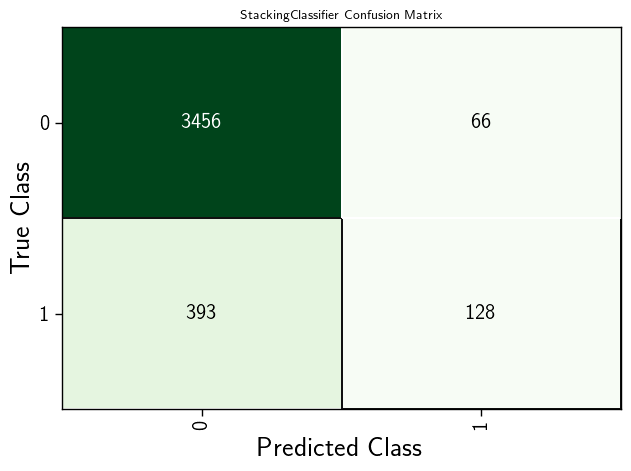

In [68]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

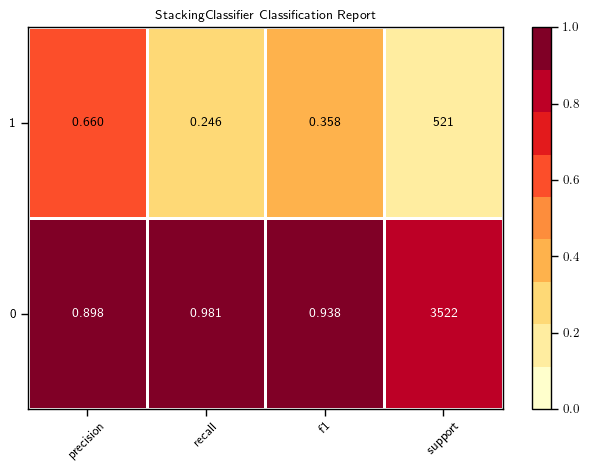

In [69]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

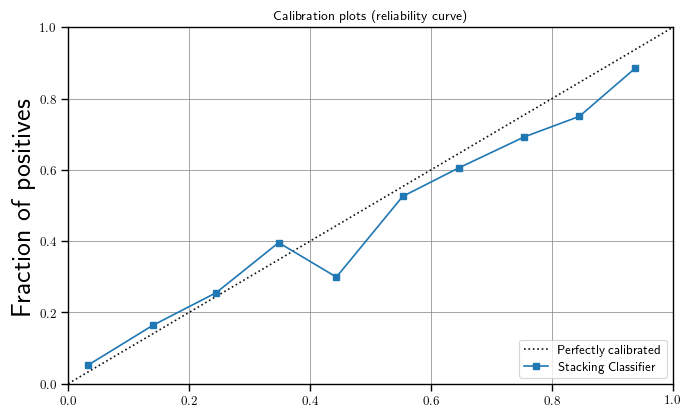

In [70]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

In [79]:
# pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [71]:
pyc.plot_model(tuned_radio_clf.final_estimator_, plot='parameter')

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.05602125190369404
loss,deviance
max_depth,9
max_features,0.5247649977209133
max_leaf_nodes,None
min_impurity_decrease,4.993651144727442e-06
min_impurity_split,None


In [72]:
pyc.plot_model(tuned_radio_clf.final_estimator, plot='parameter')

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.05602125190369404
loss,deviance
max_depth,9
max_features,0.5247649977209133
max_leaf_nodes,None
min_impurity_decrease,4.993651144727442e-06
min_impurity_split,None


In [73]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [74]:
pyc.predict_model(tuned_radio_clf, data=test_df, probability_threshold=gv.naive_radio_thresh,\
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8864704427,0.8033768547,0.2456813820,0.6597938144,0.3580419580,0.3097749495,0.3557571612,0.3431302309


,Score_0,Score_1
count,4043.000000,4043.000000
mean,0.881374,0.118626
std,0.166062,0.166062
min,0.035949,0.007159
25%,0.870963,0.024203
50%,0.949544,0.050456
75%,0.975797,0.129037
max,0.992841,0.964051


In [75]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8864704427,0.8033768547,0.2456813820,0.6597938144,0.3580419580,0.3097749495,0.3557571612,0.3431302309


In [76]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use o

In [77]:
pyc.predict_model(final_radio_clf, probability_threshold=gv.naive_radio_thresh,\
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8864704427,0.8033768547,0.2456813820,0.6597938144,0.3580419580,0.3097749495,0.3557571612,0.3431302309


,Score_0,Score_1
count,4043.000000,4043.000000
mean,0.881374,0.118626
std,0.166062,0.166062
min,0.035949,0.007159
25%,0.870963,0.024203
50%,0.949544,0.050456
75%,0.975797,0.129037
max,0.992841,0.964051


In [78]:
if save_model_flag:
    pyc.save_model(final_radio_clf, gv.models_path + gv.radio_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [59]:
if load_model_flag:
    final_radio_clf = pyc.load_model(gv.models_path + gv.radio_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [79]:
base_models_names = gf.get_base_estimators_names(final_radio_clf)
base_models       = gf.get_base_estimators_models(final_radio_clf)

In [80]:
print('Running data pre-processing:\n')
extended_data_radio_df = gf.preprocess_data(final_radio_clf, validation_df, base_models_names)

Running data pre-processing:



In [81]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_radio_clf, extended_data_radio_df)

In [82]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_radio_df)

In [83]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [84]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for xgboost...
Calculating for catboost...
Calculating for rf...
Calculating for et...


xgboost             catboost                   rf                   et  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W4mag  36.510067     W2_W3  16.203432     W2_W3   9.393072     W2_W3   
1       K_W3  21.413414     W1_W2   9.464457       y_J   8.773130       y_J   
2      W2_W3   7.003845       y_J   8.724879       g_i   8.046155       g_i   
3        g_i   3.601850       g_r   7.748572       g_r   7.618970       g_r   
4        y_J   3.362656      z_W1   7.410387      K_W3   7.537682       r_z   
5        r_z   3.010281       r_z   7.191026       r_z   7.488051     W1_W2   
6      W1_W2   2.639700       g_i   6.761955     W1_W2   7.403813      z_W1   
7       K_W4   2.562850       i_z   6.718785      z_W1   7.140619       r_i   
8       y_W1   2.536841      y_W1   6.340484       i_z   7.136466       i_z   
9       z_W1   2.508882       z_y   6.292514       r_i   7.086438       z_y   
10       g_r   2.448492      K_W3   5.426697       z_y   6.946146      y_W1   
11       z_y   2.420124       r_i   5.375940      y_W1   6.762870      K_W3   
12       r_i   2.318203      K_W4   1.814828     W4mag   3.265036     W4mag   
13       i_z   2.314675  band_num   1.565088      K_W4   2.401344  band_num   
14       J_H   1.972317       J_H   1.083799  band_num   1.330043      K_W4   
15       H_K   1.714715     W4mag   1.080497       H_K   0.974751       H_K   
16  band_num   1.661084       H_K   0.796660       J_H   0.695412       J_H   

               
   Importance  
0    9.550468  
1    7.890909  
2    7.622307  
3    7.473331  
4    7.404095  
5    7.351798  
6    7.126339  
7    7.100980  
8    7.014412  
9    6.880575  
10   6.818078  
11   5.931358  
12   5.728457  
13   2.739403  
14   1.724201  
15   0.932188  
16   0.711101

In [85]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,rf,12.024473,12.024473
1,et,7.153932,19.178406
2,catboost,7.136796,26.315202
3,xgboost,6.603711,32.918913
4,W2_W3,6.176914,39.095826
5,W1_W2,5.744287,44.840114
6,y_J,5.637576,50.477690
7,z_y,5.384907,55.862597
8,y_W1,5.228930,61.091527
9,g_i,5.212590,66.304117


In [86]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)#.drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
W2_W3,9.6085,9.6085
y_J,17.7103,8.1017
W1_W2,25.7206,8.0103
g_i,33.1664,7.4458
K_W3,40.5236,7.3572
z_y,47.8449,7.3213
y_W1,54.9948,7.1499
g_r,62.1176,7.1227
z_W1,69.1940,7.0764


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W2_W3	9.609
y_J	8.102
W1_W2	8.010
g_i	7.446
K_W3	7.357
z_y	7.321
y_W1	7.150
g_r	7.123
z_W1	7.076
r_z	6.981
i_z	6.867
r_i	6.588
W4mag	4.759
K_W4	2.280
J_H	1.283
H_K	1.030
band_num	1.018


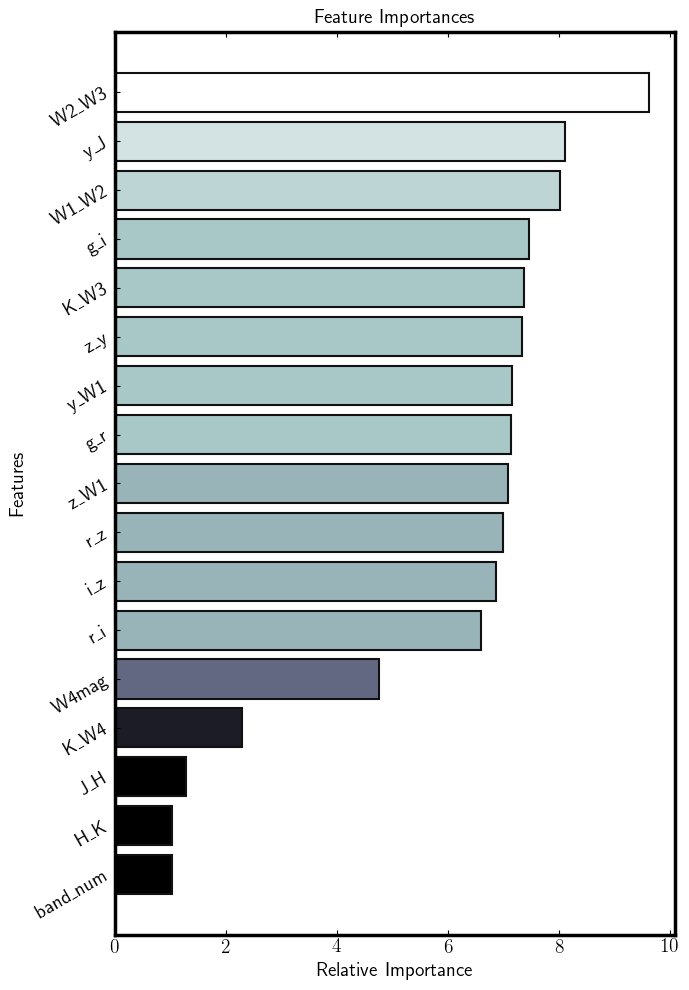

In [87]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_radio_detect_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [88]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_radio_clf, 'gbc', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,gbc,xgboost,catboost,rf,et
n_estimators,187,100.0000,NaN,100.0000,100.0000
learning_rate,0.0560,0.3000,0.0455,NaN,NaN
subsample,0.3387,1.0000,NaN,NaN,NaN
min_samples_split,5,NaN,NaN,2.0000,2.0000
min_samples_leaf,2,NaN,NaN,1.0000,1.0000
max_depth,9,6.0000,NaN,NaN,NaN
min_impurity_decrease,0.0000,NaN,NaN,0.0000,0.0000
max_features,0.5248,NaN,NaN,auto,auto
colsample_bytree,NaN,1.0000,NaN,NaN,NaN
min_child_weight,NaN,1.0000,NaN,NaN,NaN


---

In [89]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 32,344
Size of test set is  4,043


#### Calculate optimal threshold for classification

In [90]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8630657927,0.8648918795,0.3057932046,0.4404929577,0.3609868706,0.2870905984,0.2930943167,0.3549000025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8864704427,0.8033768547,0.2456813820,0.6597938144,0.3580419580,0.3097749495,0.3557571612,0.3431302309


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8673509770,0.8538288483,0.2919351689,0.4625618812,0.3579552257,0.2881837695,0.2976923031,0.3504249454


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8825129854,0.8081805375,0.2278978389,0.5858585859,0.3281471004,0.2771762061,0.3146428956,0.3149811327


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8761377127,0.7924788245,0.1949152542,0.5500000000,0.2878270762,0.2365201502,0.2751612474,0.2753548324


#### Naive threshold metrics.

In [91]:
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [92]:
naive_scores_df = gf.create_scores_df([cm_mat_train_naive, cm_mat_test_naive, cm_mat_train_test_naive, cm_mat_calib_naive, cm_mat_val_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [93]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.3549,0.2931,0.4405,0.3058
Test,0.3431,0.3558,0.6598,0.2457
Train+Test,0.3504,0.2977,0.4626,0.2919
Calibration,0.3150,0.3146,0.5859,0.2279
Validation,0.2754,0.2752,0.5500,0.1949


#### Calibration curve

In [94]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

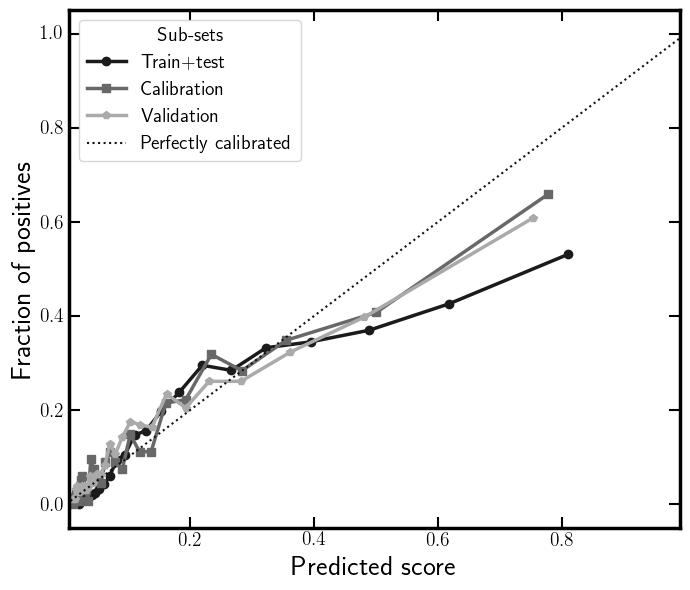

In [95]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

min_x = np.nanmin([np.nanmin(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(validation_prediction_clf.loc[:, 'Score_1'])])
max_x = np.nanmax([np.nanmax(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(validation_prediction_clf.loc[:, 'Score_1'])])

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=min_x * 0.99999, right=max_x * 1.00001)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_radio.pdf', bbox_inches='tight')
plt.show()

#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [96]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [97]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.86489
Area under the curve (ROC) for test       = 0.80338
Area under the curve (ROC) for train+test = 0.85383
Area under the curve (ROC) for calibraton = 0.80818
Area under the curve (ROC) for validation = 0.79248


In [98]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

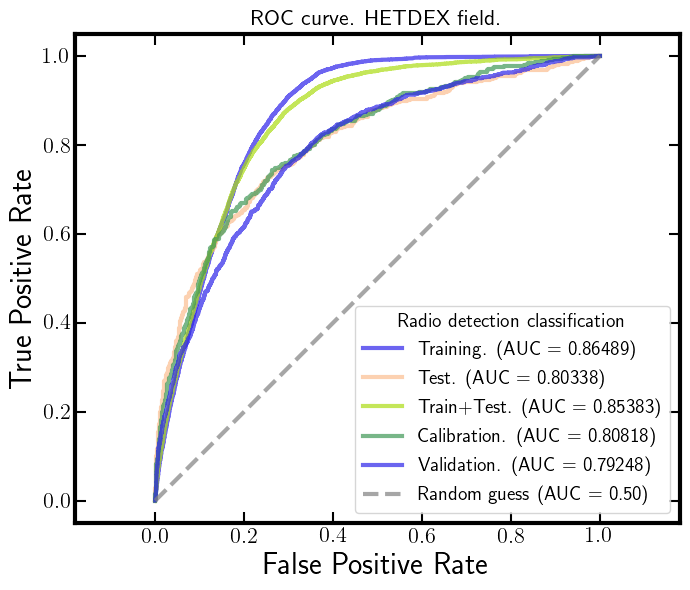

In [99]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=22)
ax1.set_ylabel('True Positive Rate', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

##### Obtain optimal thresholds from each sub-set

In [100]:
opt_thres_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_thres_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_thres_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_thres_calib      = thresh_calib[np.argmax(tpr_calib - fpr_calib)]
opt_thres_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [101]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_thres_train:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_thres_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_thres_train_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_thres_calib:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_thres_validation:.8e}')

Optimal threshold from area under the curve (ROC) for training    = 1.04163532e-01
Optimal threshold from area under the curve (ROC) for test        = 1.01613812e-01
Optimal threshold from area under the curve (ROC) for train+test  = 1.04163532e-01
Optimal threshold from area under the curve (ROC) for calibration = 9.93809213e-02
Optimal threshold from area under the curve (ROC) for validation  = 8.97767013e-02


##### Precision-Recall curve

In [102]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [103]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

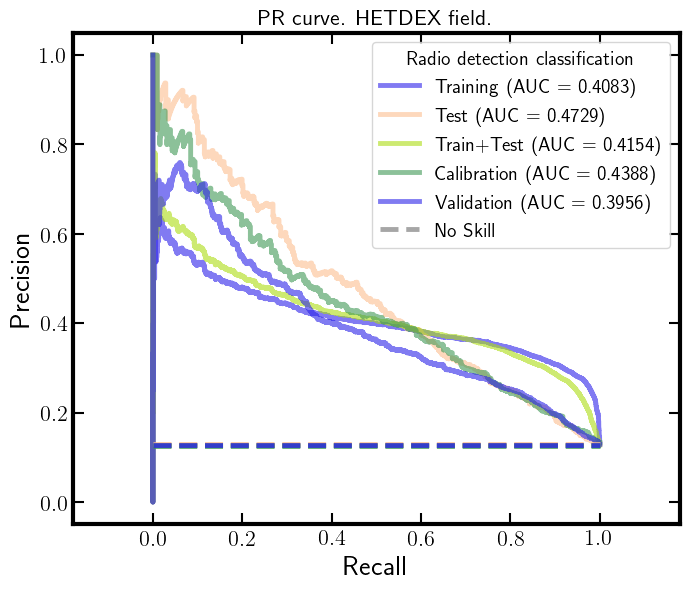

In [104]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc='best', fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [105]:
fscore_train      = (1 + gv.beta_F**2) * (prec_train      * recall_train)      / (prec_train * gv.beta_F**2      + recall_train)
fscore_test       = (1 + gv.beta_F**2) * (prec_test       * recall_test)       / (prec_test * gv.beta_F**2       + recall_test)
fscore_train_test = (1 + gv.beta_F**2) * (prec_train_test * recall_train_test) / (prec_train_test * gv.beta_F**2 + recall_train_test)
fscore_calib      = (1 + gv.beta_F**2) * (prec_calib      * recall_calib)      / (prec_calib * gv.beta_F**2      + recall_calib)
fscore_validation = (1 + gv.beta_F**2) * (prec_validation * recall_validation) / (prec_validation * gv.beta_F**2 + recall_validation)

In [106]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [107]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.8e}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.8e}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.8e}')

Optimal threshold from Precision-Recall curve for training    = 9.78842941e-01
Optimal threshold from Precision-Recall curve for test        = 1.69519258e-01
Optimal threshold from Precision-Recall curve for train+test  = 9.81536988e-01
Optimal threshold from Precision-Recall curve for calibration = 1.85561100e-01
Optimal threshold from Precision-Recall curve for validation  = 9.80621380e-01


In [108]:
print(f'The selected threshold, from train+test sub-set is {opt_t_PR_train_test:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_train_test}')

The selected threshold, from train+test sub-set is 0.98154
And, in its complete extension, is 0.9815369877


---

In [109]:
radio_pred_threshold = float(opt_t_PR_train_test) # 4.97101925e-01

In [110]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=radio_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8734541182,0.8648918795,0.0000000000,0.0000000000,0.0000000000,-0.0001236254,-0.0029923612,0.0000000000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8711352956,0.8033768547,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8732871630,0.8538288483,0.0000000000,0.0000000000,0.0000000000,-0.0000989076,-0.0026786042,0.0000000000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8741033886,0.8081805375,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8714879304,0.7924788245,0.0000000000,0.0000000000,0.0000000000,-0.0001977499,-0.0038180205,0.0000000000


Create confusion matrices.

In [111]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [112]:
radio_scores_array_df = gf.create_scores_df([cm_mat_train, cm_mat_test, cm_mat_train_test, cm_mat_calib, cm_mat_val],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [113]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_array_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.0000,-0.0030,0.0000,0.0000
Test,0.0000,NaN,NaN,0.0000
Train+Test,0.0000,-0.0027,0.0000,0.0000
Calibration,0.0000,NaN,NaN,0.0000
Validation,0.0000,-0.0038,0.0000,0.0000


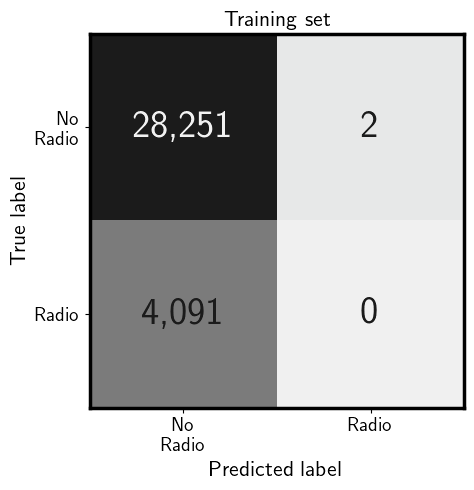

In [114]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

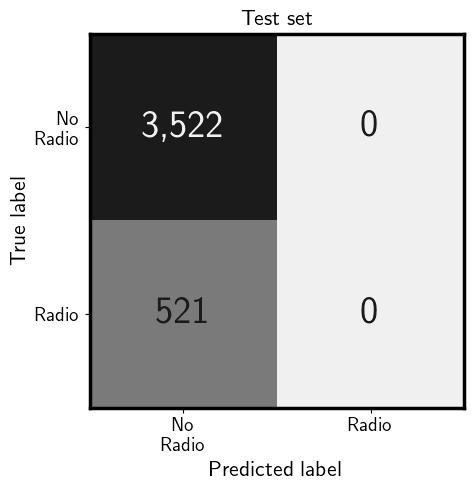

In [115]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

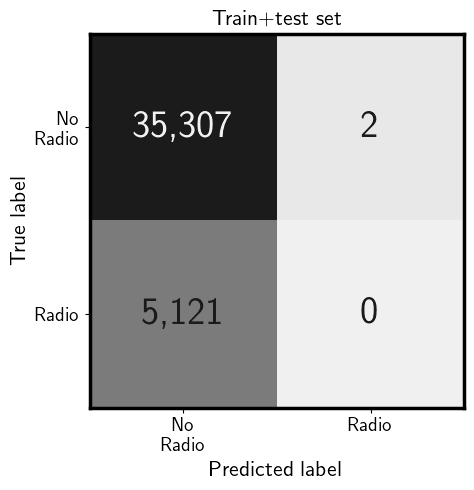

In [116]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

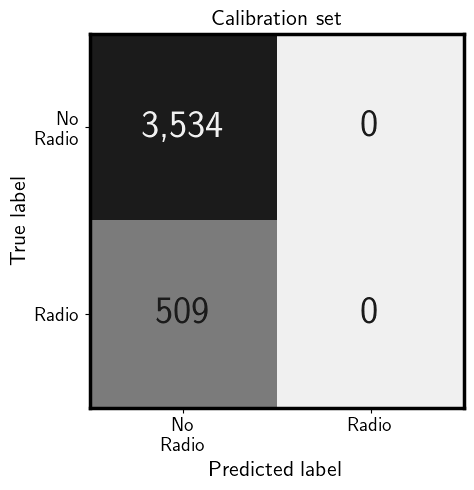

In [117]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

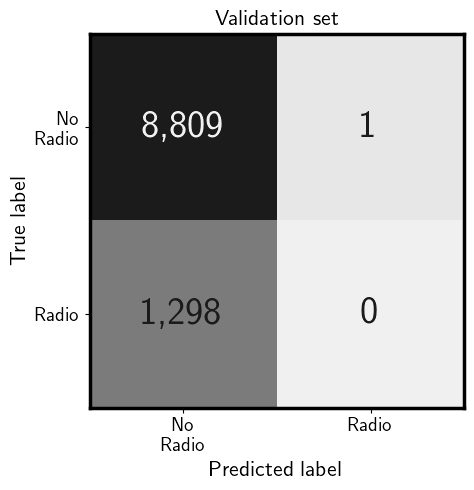

In [118]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [119]:
print('Running data pre-processing for calibration (train+test):\n')
extended_calibration_df = gf.preprocess_data(final_radio_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (train+test):



In [120]:
if not save_model_flag:
    calibrated_final_radio_clf = BetaCalibration(parameters='abm')
    calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])

In [123]:
if save_model_flag:
    calibrated_final_radio_clf = BetaCalibration(parameters='abm')
    calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
    dump(calibrated_final_radio_clf, gv.models_path + gv.cal_radio_model)

In [122]:
if load_model_flag:
    calibrated_final_radio_clf = load(gv.models_path + gv.cal_radio_model)

FileNotFoundError: [Errno 2] No such file or directory: 'models/cal_classification_LOFAR_detect_dec_19_2022.joblib'

In [124]:
train_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_radio']       = calibrated_final_radio_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

In [125]:
train_prediction_clf['Label_cal_naive']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
test_prediction_clf['Label_cal_naive']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= gv.naive_radio_thresh).astype(int)
train_test_prediction_clf['Label_cal_naive'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)
calib_prediction_clf['Label_cal_naive']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
validation_prediction_clf['Label_cal_naive'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)

In [126]:
cm_mat_val_cal_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal_naive'])
cm_mat_train_cal_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal_naive'])
cm_mat_test_cal_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal_naive'])
cm_mat_calib_cal_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal_naive'])
cm_mat_train_test_cal_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal_naive'])

In [127]:
radio_scores_cal_naive_df = gf.create_scores_df([cm_mat_train_cal_naive, cm_mat_test_cal_naive,\
                                              cm_mat_train_test_cal_naive, cm_mat_calib_cal_naive, cm_mat_val_cal_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [128]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_naive_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.3099,0.2685,0.4583,0.2444
Test,0.3080,0.3400,0.6918,0.2111
Train+Test,0.3078,0.2762,0.4846,0.2365
Calibration,0.2884,0.3121,0.6392,0.1984
Validation,0.2487,0.2736,0.6061,0.1672


##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [129]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_radio'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)

AUC for PR curve

In [130]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

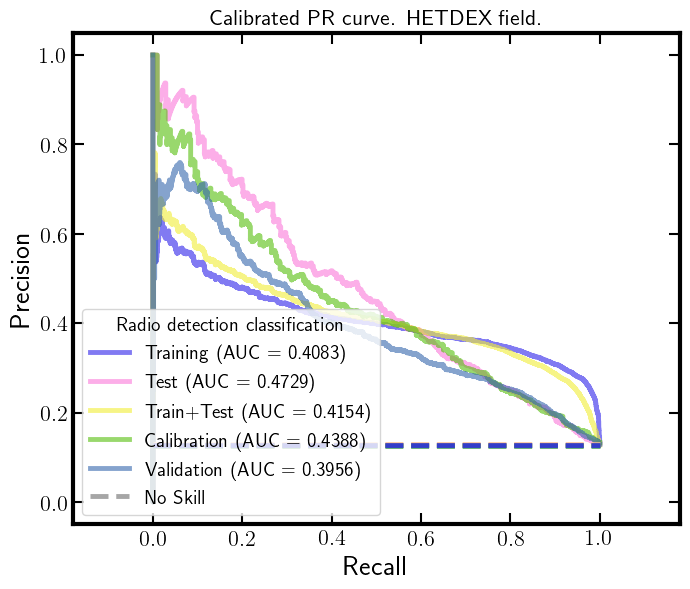

In [131]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib_cal,      recall=recall_calib_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [132]:
fscore_train_cal      = (1 + gv.beta_F**2) * (prec_train_cal      * recall_train_cal)      / (prec_train_cal * gv.beta_F**2      + recall_train_cal)
fscore_test_cal       = (1 + gv.beta_F**2) * (prec_test_cal       * recall_test_cal)       / (prec_test_cal * gv.beta_F**2       + recall_test_cal)
fscore_train_test_cal = (1 + gv.beta_F**2) * (prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal * gv.beta_F**2 + recall_train_test_cal)
fscore_calib_cal      = (1 + gv.beta_F**2) * (prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal * gv.beta_F**2      + recall_calib_cal)
fscore_validation_cal = (1 + gv.beta_F**2) * (prec_validation_cal * recall_validation_cal) / (prec_validation_cal * gv.beta_F**2 + recall_validation_cal)

In [133]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [134]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.86766
Optimal threshold from Precision-Recall curve for test        = 0.18946
Optimal threshold from Precision-Recall curve for train+test  = 0.87481
Optimal threshold from Precision-Recall curve for calibration = 0.20460
Optimal threshold from Precision-Recall curve for validation  = 0.87231


In [135]:
print(f'The selected threshold, from calibration sub-set is {opt_t_PR_calib_cal:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_calib_cal}')

The selected threshold, from calibration sub-set is 0.20460
And, in its complete extension, is 0.2046047064139296


In [136]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= opt_t_PR_calib_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)

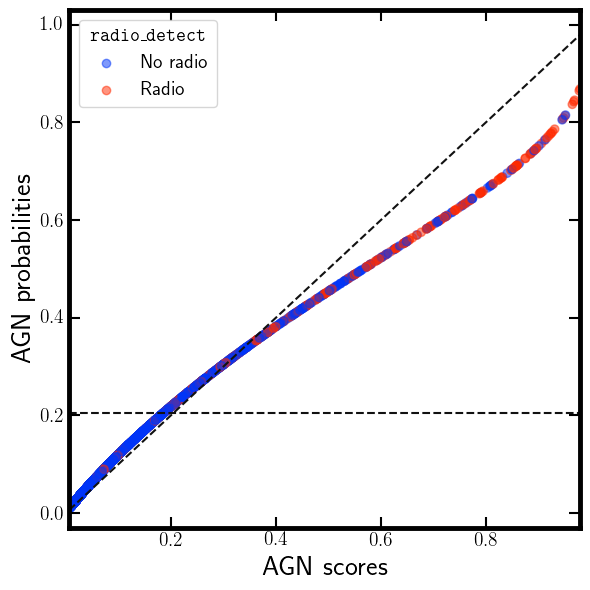

In [137]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(set_to_plot.loc[:, 'Score_1'], set_to_plot.loc[:, 'Prob_radio'], marker='o',\
            alpha=0.5, c=set_to_plot.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_calib_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
ax1.set_xlim(left=set_to_plot.loc[:, 'Score_1'].min() * 0.99999, right=set_to_plot.loc[:, 'Score_1'].max() * 1.00001)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

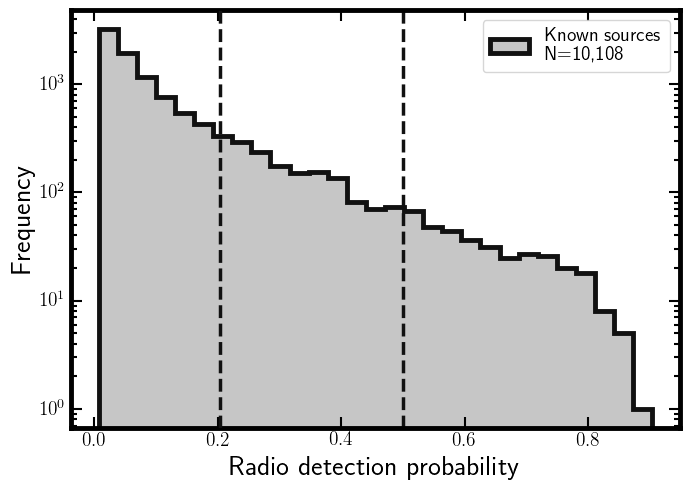

In [138]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

set_to_plot     = validation_prediction_clf

min_score  = np.nanmin(set_to_plot.loc[:, 'Prob_radio'])
max_score  = np.nanmax(set_to_plot.loc[:, 'Prob_radio'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(set_to_plot.loc[:, 'Prob_radio'])

ax1.hist(set_to_plot.loc[:, 'Prob_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_calib_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_radio_cal_scores_pred_AGN_known.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [139]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

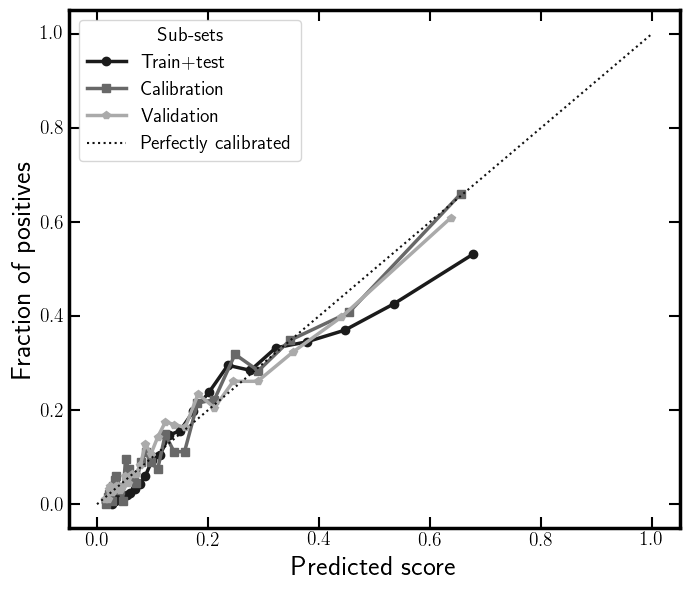

In [140]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_radio.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).  
Its values can be in the range $[0, 1]$

If BSS $\ll 0$, calibration was not succesful. If BSS $\approx 0$, it performs as the previous model.  
If BSS $\gg 0$, calibration is useful and performs better than original model.

In [141]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [142]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is -0.434 using the validation set.


Create confusion matrices.

In [143]:
cm_mat_val_cal        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal'])
cm_mat_train_cal      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal'])
cm_mat_test_cal       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal'])
cm_mat_calib_cal      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal'])
cm_mat_train_test_cal = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal'])

In [144]:
radio_scores_cal_df = gf.create_scores_df([cm_mat_train_cal, cm_mat_test_cal,\
                                              cm_mat_train_test_cal, cm_mat_calib_cal, cm_mat_val_cal],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [145]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.4997,0.4153,0.3582,0.7416
Test,0.4720,0.3770,0.3975,0.5585
Train+Test,0.4953,0.4072,0.3634,0.7075
Calibration,0.4759,0.3826,0.3880,0.5855
Validation,0.4288,0.3247,0.3528,0.5216


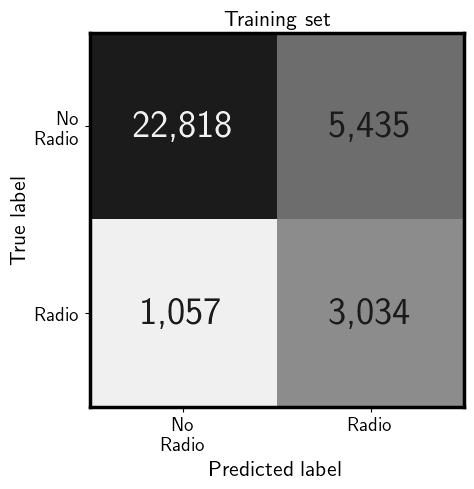

In [146]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_cal, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

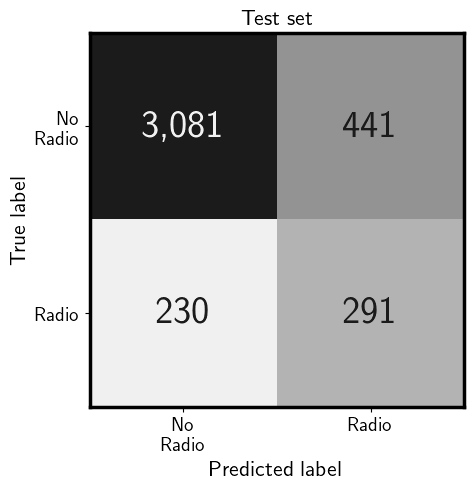

In [147]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test_cal, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

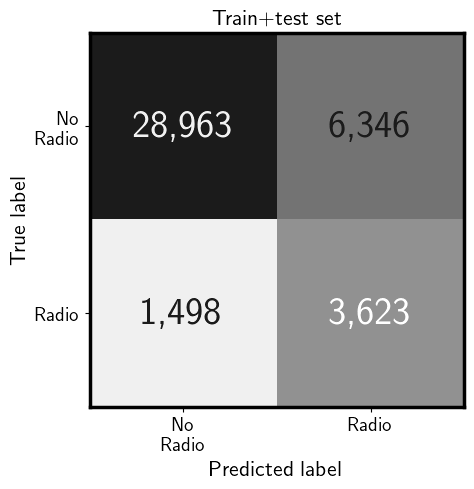

In [148]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_mat_train_test_cal, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

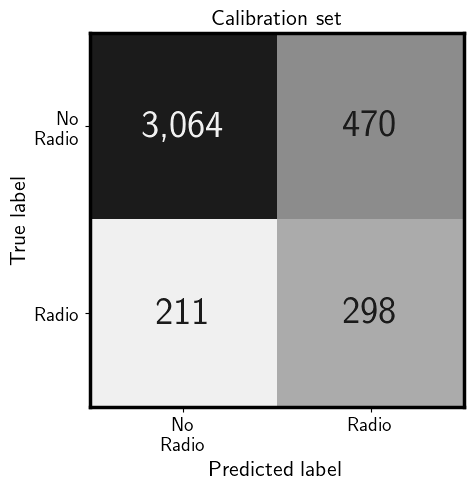

In [149]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib_cal, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

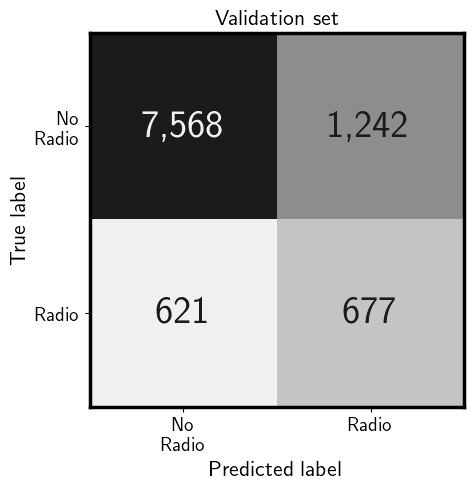

In [150]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val_cal, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()